In [2]:
import pandas as pd
pd.set_option('max_colwidth', 100)
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
import itertools
import scipy.stats as st
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
import rpy2
import pingouin as pg

In [3]:
# ICC - https://www.uvm.edu/~statdhtx/methods8/Supplements/icc/More%20on%20ICCs.pdf
# ICC(2,1) - Each subject is measured by each rater, and raters are considered representative
#            of a larger population of similar raters. 
#            Reliability calculated from a single measurement.

In [4]:
# I found two python implementations:
#     1 - pinguoin 
#     https://pingouin-stats.org/build/html/generated/pingouin.intraclass_corr.html
#     2 - rpy2
#     https://www.r-bloggers.com/2021/06/intraclass-correlation-coefficient-in-r-quick-guide/
#     also:
#     https://stackoverflow.com/questions/40965579/intraclass-correlation-in-python-module

In [5]:
# ICC(2,1) for : 
# total score of HITOP
# total score of BAARS
# each subscale of HITOP
# each subscale of BAARS-IV
# GAD-7
# PHQ-8

In [6]:
# general
#data_path = '../data/mydata_1general_forICC_removedGRIDchecks.csv'
#path_to_save = '../results/ICC_genpop_removedGRIDchecks.csv'

#highrisk
#data_path = '../data/mydata_1highrisk_forICC_removedGRIDchecks.csv'
#path_to_save = '../results/ICC_enriched_removedGRIDchecks.csv'

mydata = pd.read_csv(data_path)
mydata = mydata.rename(columns={'Unnamed: 0': 'Subject'})
mydata.head()

NameError: name 'data_path' is not defined

In [7]:
# Only run this if combining samples

data_path_genpop = '../data/mydata_1general_forICC_removedGRIDchecks.csv'
data_path_enriched = '../data/mydata_1highrisk_forICC_removedGRIDchecks.csv'
path_to_save = '../results/ICC_genpopANDenriched_removedGRIDchecks.csv'

mydata_genpop = pd.read_csv(data_path_genpop)
mydata_enriched = pd.read_csv(data_path_enriched)

mydata = pd.concat([mydata_genpop, mydata_enriched])
mydata = mydata.rename(columns={'Unnamed: 0': 'Subject'})
mydata.head()

,Subject,hitop_sum,hitop_sum_recontact,baars_sum,baars_sum_recontact,phq_sum,phq_sum_recontact,gad_sum,gad_sum_recontact,mood_bothered,mood_bothered_recontact,anxiety_bothered,anxiety_bothered_recontact,attention_bothered,attention_bothered_recontact,moodanxiety_bothered,moodanxiety_bothered_recontact,baars_inattention_sum,baars_inattention_sum_recontact,baars_hyperactivity_sum,baars_hyperactivity_sum_recontact,baars_impulsivity_sum,baars_impulsivity_sum_recontact,baars_sct_sum,baars_sct_sum_recontact,hitop_anhedonic_depression,hitop_anhedonic_depression_recontact,hitop_anxious_worry,hitop_anxious_worry_recontact,hitop_appetite_gain,hitop_appetite_gain_recontact,hitop_appetite_loss,hitop_appetite_loss_recontact,hitop_cognitive_problems,hitop_cognitive_problems_recontact,hitop_hyposomnia,hitop_hyposomnia_recontact,hitop_indecisiveness,hitop_indecisiveness_recontact,hitop_insomnia,hitop_insomnia_recontact,hitop_panic,hitop_panic_recontact,hitop_separation_insecurity,hitop_separation_insecurity_recontact,hitop_shame_guilt,hitop_shame_guilt_recontact,hitop_situational_phobia,hitop_situational_phobia_recontact,hitop_social_anxiety,hitop_social_anxiety_recontact,hitop_well_being,hitop_well_being_recontact
0,0,39,22,16,11,7,3,10,6,False,False,False,False,False,False,False,False,7,4,7,7,2,0,15,9,2,3,11,6,5,4,0,0,6,2,0,0,3,1,1,2,0,0,4,2,2,0,0,0,5,2,28,26
1,1,93,77,12,11,4,6,6,4,False,False,False,False,False,False,False,False,6,5,3,4,3,2,11,9,10,10,13,9,5,4,2,4,6,4,5,6,3,4,4,8,12,5,3,0,3,0,10,10,17,13,27,26
2,3,17,29,4,3,0,0,0,0,False,False,False,False,False,False,False,False,4,2,0,1,0,0,3,1,1,4,0,5,3,0,0,6,1,1,0,0,0,1,6,4,1,3,0,1,0,1,4,3,1,0,13,11
3,4,92,77,16,18,13,9,4,7,False,False,False,False,False,False,False,False,8,10,3,4,5,4,11,11,16,15,6,10,12,7,0,4,9,8,2,2,3,4,10,7,9,5,8,4,4,4,2,0,11,7,8,4
4,5,65,48,17,14,10,6,8,5,False,False,True,True,False,False,True,True,9,9,6,3,2,2,8,8,10,8,9,7,4,4,3,0,7,4,0,0,3,3,0,0,2,3,4,1,4,2,3,1,16,15,15,13


In [8]:
def do_icc(data, measure, show = True):
    # just the measure of interest
    data_measure = data[['Subject', measure, measure+'_recontact']]
    data_measure = data_measure.rename(columns={measure: "Original", measure+'_recontact': "Recontact"})
    data_measure_melted = pd.melt(data_measure, id_vars='Subject', value_vars=['Original','Recontact'], value_name='Score')
    data_measure_melted = data_measure_melted.rename(columns={"variable": "Session"})
    # adding Measure - don't really need to do it but eh
    shape = data_measure_melted.shape
    data_measure_melted['Measure'] = [measure] * shape[0]
    print(measure)
    icc = pg.intraclass_corr(data=data_measure_melted, targets='Subject', raters='Session', ratings='Score').round(3)
    icc.set_index("Type")
    #print(icc)
    if show:
        plt = sns.jointplot(data=data_measure, x='Original', y='Recontact')
        plt.fig.suptitle(measure)
        #plt = plt.set(title=measure)
        #plt.subtitle(measure)
        #plt.show()
        print(icc)
    return (icc)

In [9]:
def create_table (data, measures):
    df_init = pd.DataFrame()
    for measure in measures:
        if 'bothered' not in measure:
            print(measure)
            new_icc = do_icc(data, measure, show=False)
            new_icc_row = new_icc.iloc[['1']]
            new_icc_row['Measure'] = measure
            df_init = pd.concat([df_init, new_icc_row], axis = 0)
    df_result = df_init
    return (df_result)

hitop_sum
    Type              Description    ICC       F  df1  df2  pval         CI95%
0   ICC1   Single raters absolute  0.927  26.416  433  434   0.0  [0.91, 0.94]
1   ICC2     Single random raters  0.927  26.457  433  433   0.0  [0.91, 0.94]
2   ICC3      Single fixed raters  0.927  26.457  433  433   0.0  [0.91, 0.94]
3  ICC1k  Average raters absolute  0.962  26.416  433  434   0.0  [0.95, 0.97]
4  ICC2k    Average random raters  0.962  26.457  433  433   0.0  [0.95, 0.97]
5  ICC3k     Average fixed raters  0.962  26.457  433  433   0.0  [0.95, 0.97]
baars_sum
    Type              Description    ICC       F  df1  df2  pval         CI95%
0   ICC1   Single raters absolute  0.889  17.012  433  434   0.0  [0.87, 0.91]
1   ICC2     Single random raters  0.889  16.992  433  433   0.0  [0.87, 0.91]
2   ICC3      Single fixed raters  0.889  16.992  433  433   0.0  [0.87, 0.91]
3  ICC1k  Average raters absolute  0.941  17.012  433  434   0.0  [0.93, 0.95]
4  ICC2k    Average random rater

/Users/zeleninam2/Documents/projects/hitop/2-analysis-CFA/env/lib/python3.9/site-packages/seaborn/axisgrid.py:1696: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure(figsize=(height, height))


    Type              Description    ICC       F  df1  df2  pval         CI95%
0   ICC1   Single raters absolute  0.890  17.191  433  434   0.0  [0.87, 0.91]
1   ICC2     Single random raters  0.890  17.213  433  433   0.0  [0.87, 0.91]
2   ICC3      Single fixed raters  0.890  17.213  433  433   0.0  [0.87, 0.91]
3  ICC1k  Average raters absolute  0.942  17.191  433  434   0.0  [0.93, 0.95]
4  ICC2k    Average random raters  0.942  17.213  433  433   0.0  [0.93, 0.95]
5  ICC3k     Average fixed raters  0.942  17.213  433  433   0.0  [0.93, 0.95]
hitop_well_being
    Type              Description    ICC       F  df1  df2  pval         CI95%
0   ICC1   Single raters absolute  0.867  14.010  433  434   0.0  [0.84, 0.89]
1   ICC2     Single random raters  0.867  13.989  433  433   0.0  [0.84, 0.89]
2   ICC3      Single fixed raters  0.867  13.989  433  433   0.0  [0.84, 0.89]
3  ICC1k  Average raters absolute  0.929  14.010  433  434   0.0  [0.91, 0.94]
4  ICC2k    Average random raters  

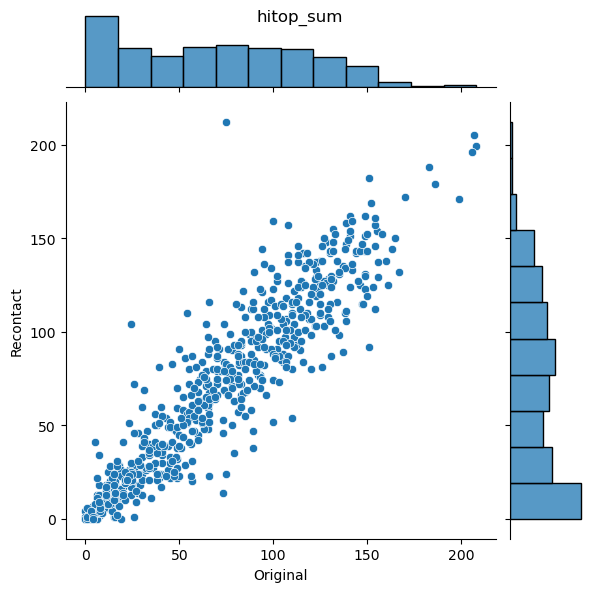

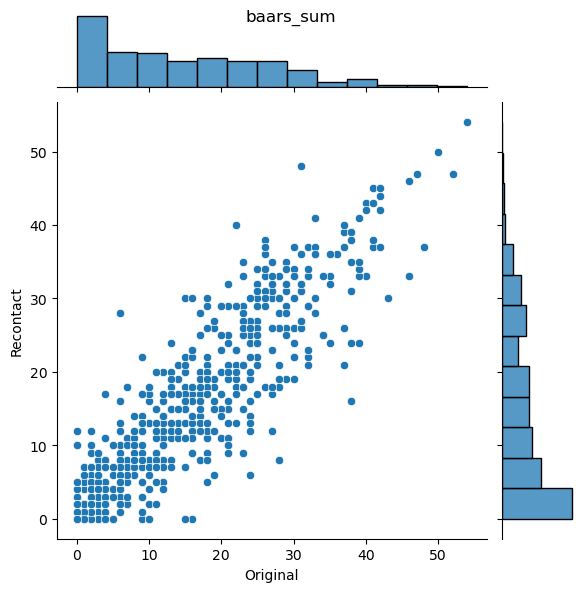

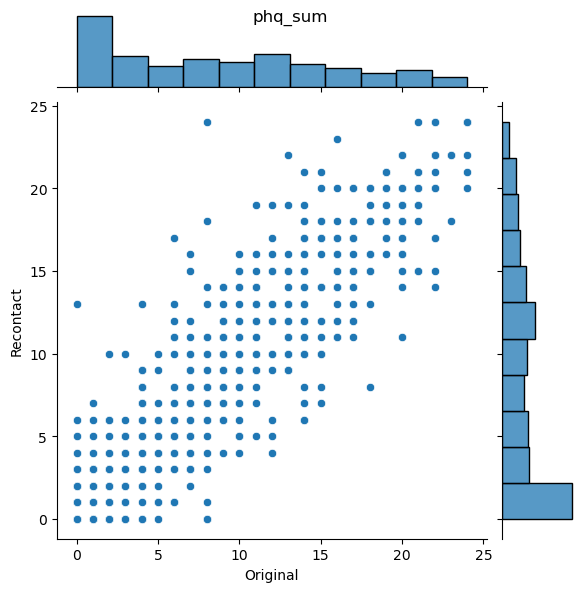

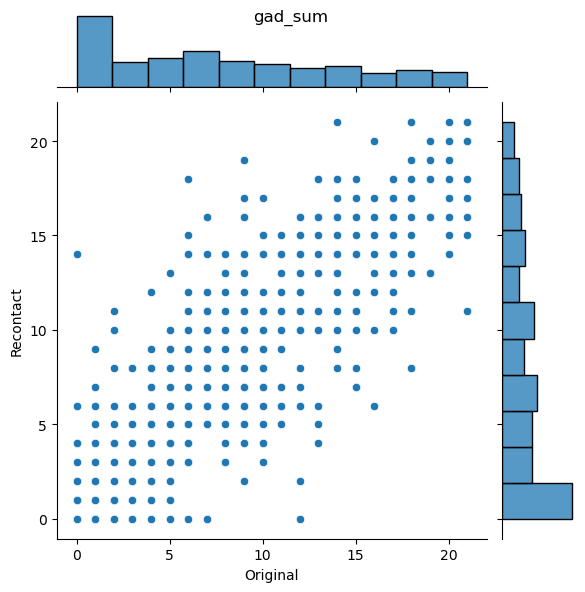

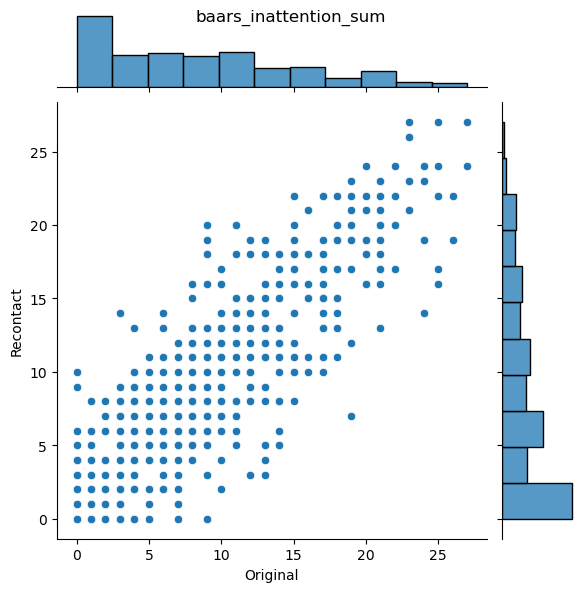

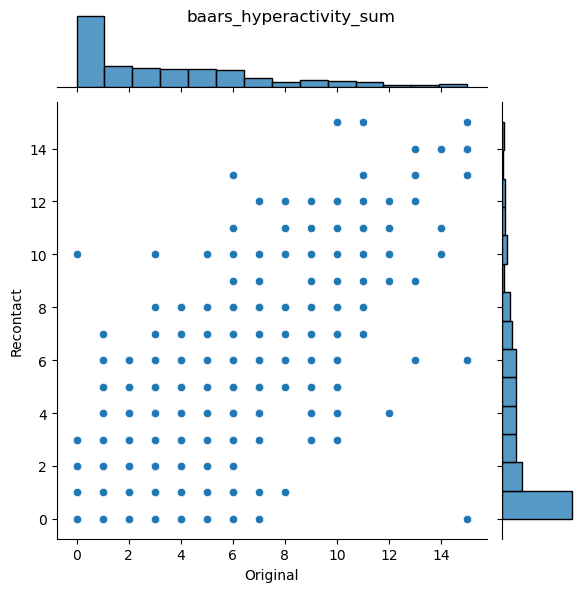

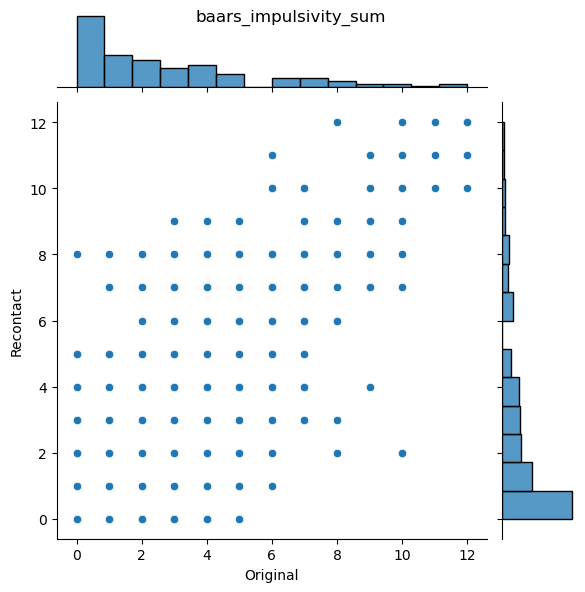

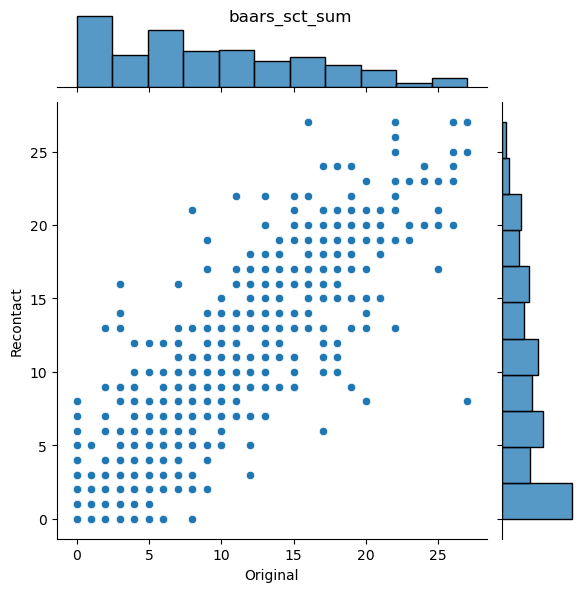

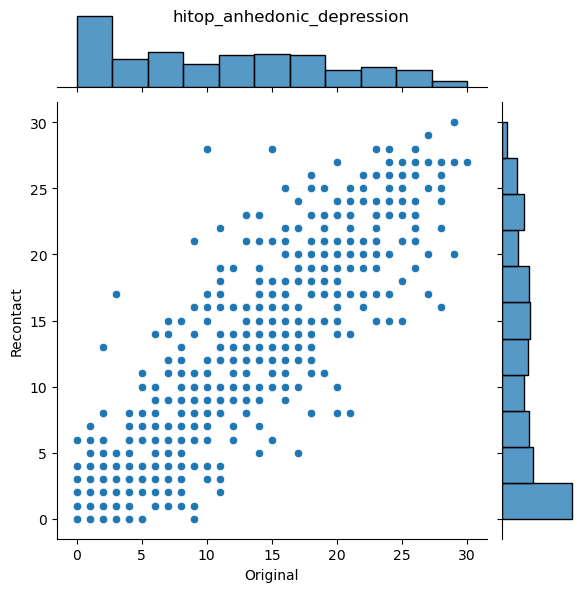

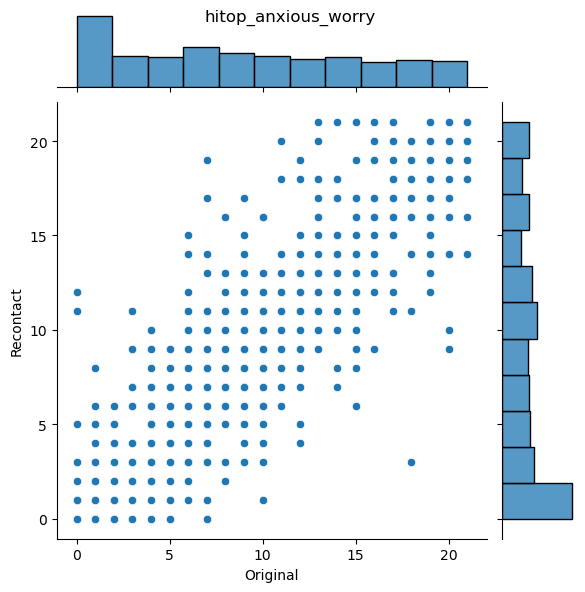

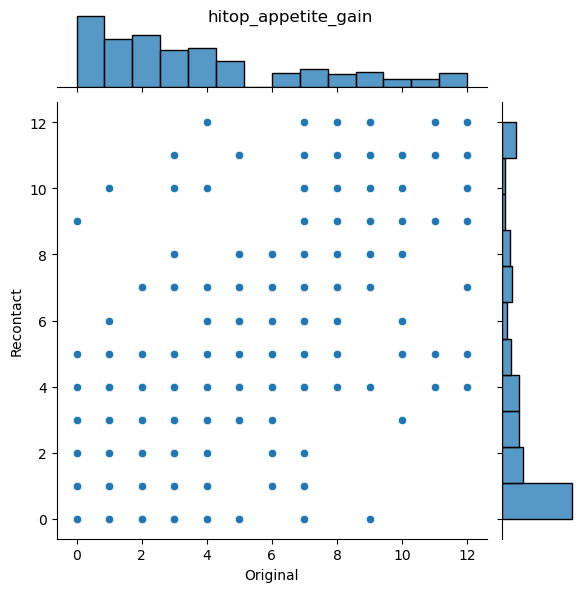

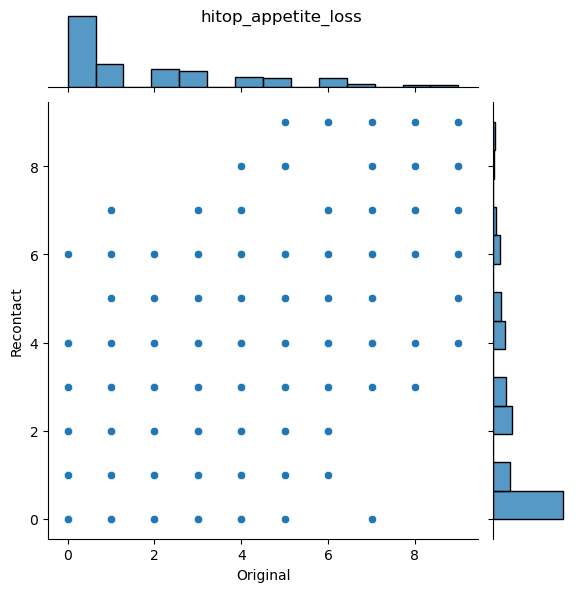

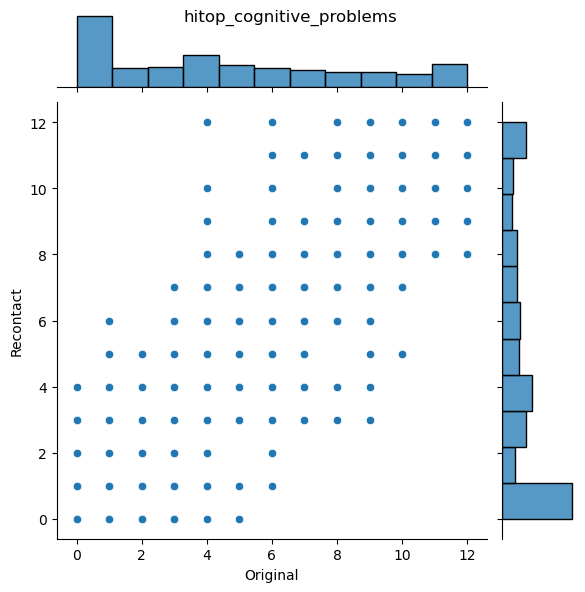

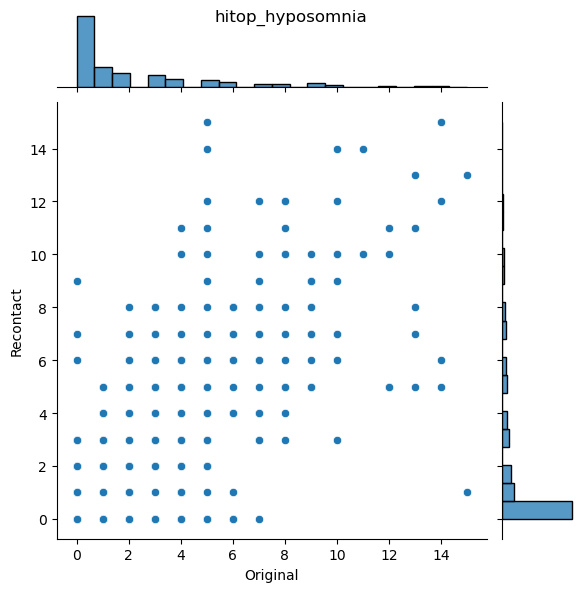

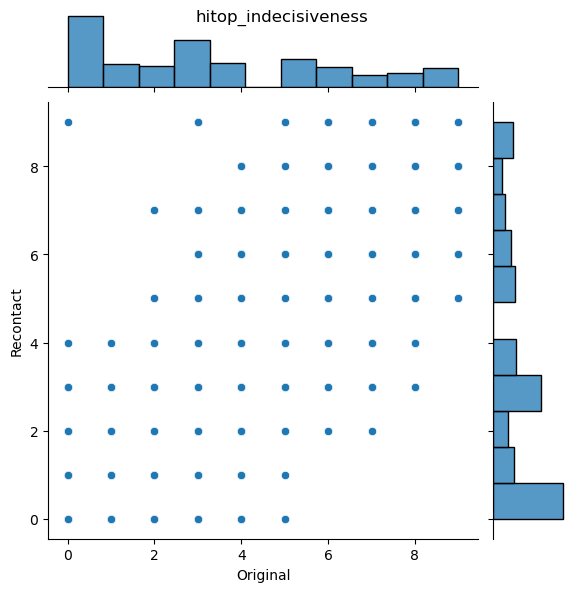

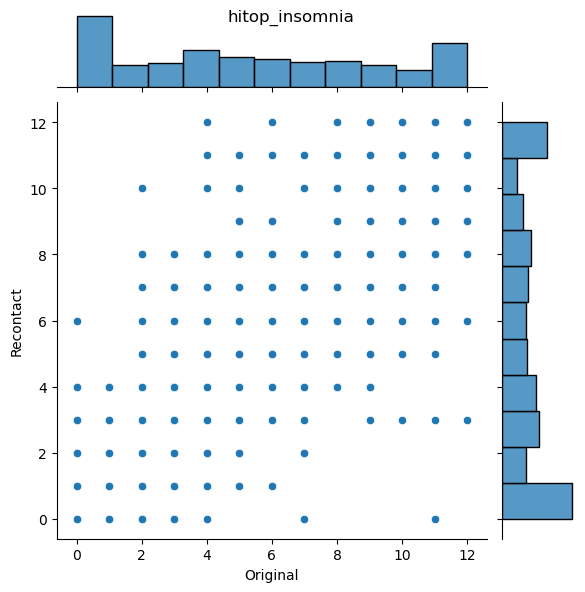

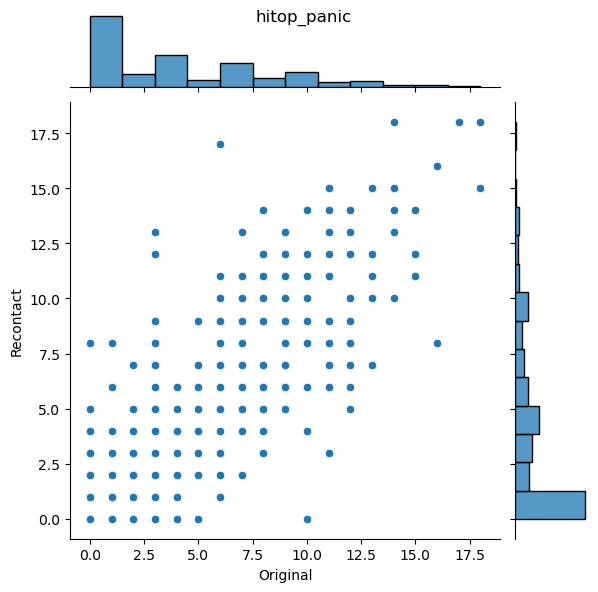

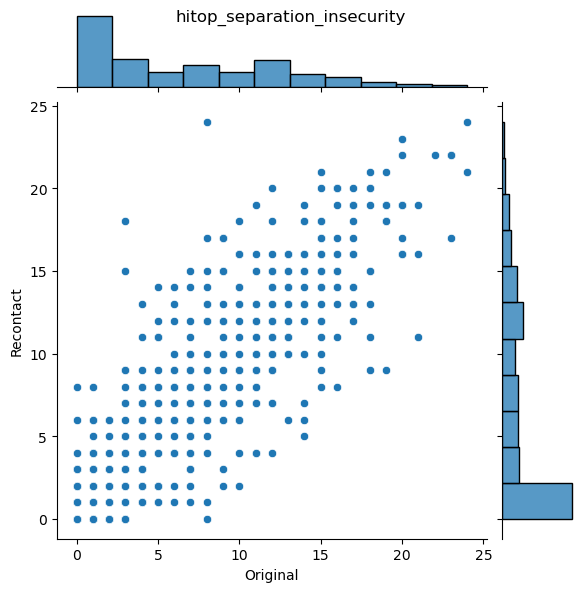

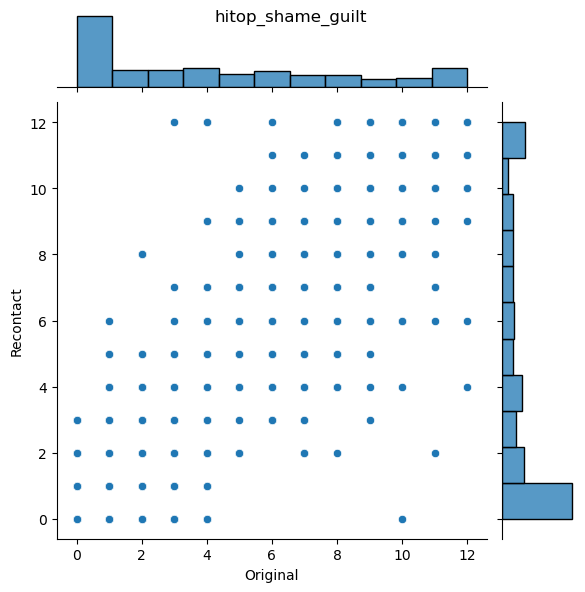

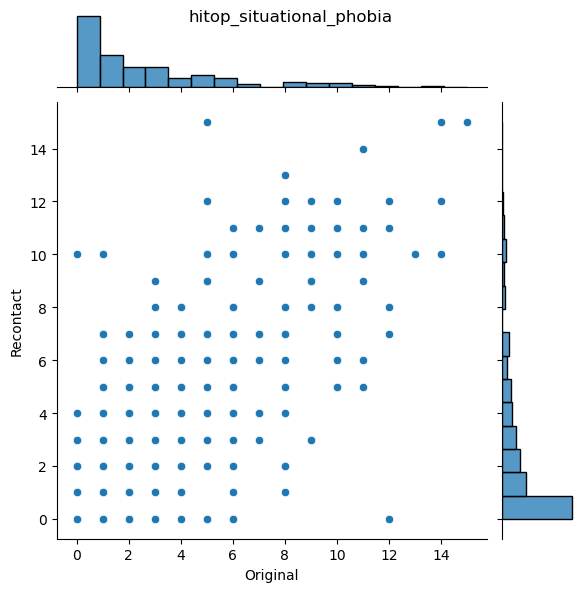

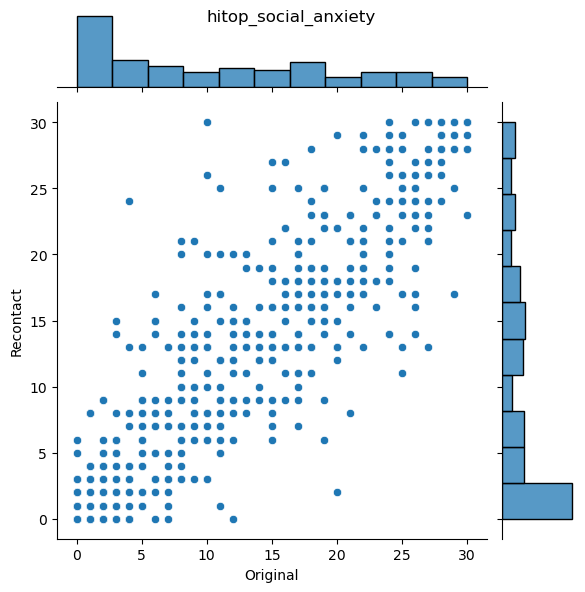

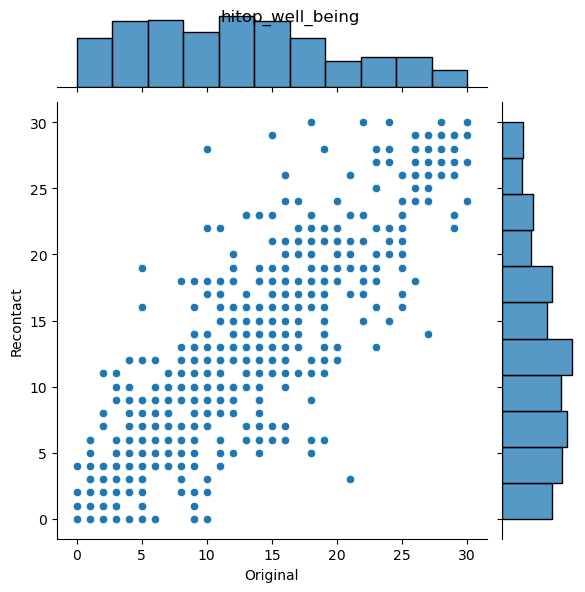

In [10]:
measures_for_icc = ['hitop_sum', 'baars_sum', 'phq_sum', 'gad_sum', \
                   'baars_inattention_sum', 'baars_hyperactivity_sum', 'baars_impulsivity_sum', 'baars_sct_sum',\
                   'hitop_anhedonic_depression', 'hitop_anxious_worry', 'hitop_appetite_gain',\
                   'hitop_appetite_loss', 'hitop_cognitive_problems', 'hitop_hyposomnia', 'hitop_indecisiveness'\
                   'hitop_insomnia', 'hitop_panic', 'hitop_separation_insecurity', 'hitop_shame_guilt',\
                   'hitop_situational_phobia', 'hitop_social_anxiety', 'hitop_well_being']
for measure in measure_for_icc:
    if 'bothered' not in measure:
        do_icc(mydata, measure)

In [11]:
results_table = create_table(mydata, measures_for_icc)
results_table

hitop_sum
hitop_sum
baars_sum
baars_sum


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


phq_sum
phq_sum
gad_sum
gad_sum


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


baars_inattention_sum
baars_inattention_sum
baars_hyperactivity_sum
baars_hyperactivity_sum


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


baars_impulsivity_sum
baars_impulsivity_sum
baars_sct_sum
baars_sct_sum


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


hitop_anhedonic_depression
hitop_anhedonic_depression
hitop_anxious_worry
hitop_anxious_worry


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


hitop_appetite_gain
hitop_appetite_gain
hitop_appetite_loss
hitop_appetite_loss


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


hitop_cognitive_problems
hitop_cognitive_problems
hitop_hyposomnia
hitop_hyposomnia


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


hitop_indecisiveness
hitop_indecisiveness
hitop_insomnia
hitop_insomnia


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


hitop_panic
hitop_panic
hitop_separation_insecurity
hitop_separation_insecurity


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


hitop_shame_guilt
hitop_shame_guilt
hitop_situational_phobia
hitop_situational_phobia


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


hitop_social_anxiety
hitop_social_anxiety
hitop_well_being
hitop_well_being


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


,Type,Description,ICC,F,df1,df2,pval,CI95%,Measure
1,ICC2,Single random raters,0.927,26.457,433,433,0.0,"[0.91, 0.94]",hitop_sum
1,ICC2,Single random raters,0.889,16.992,433,433,0.0,"[0.87, 0.91]",baars_sum
1,ICC2,Single random raters,0.897,18.370,433,433,0.0,"[0.88, 0.91]",phq_sum
1,ICC2,Single random raters,0.860,13.218,433,433,0.0,"[0.83, 0.88]",gad_sum
1,ICC2,Single random raters,0.869,14.210,433,433,0.0,"[0.84, 0.89]",baars_inattention_sum
1,ICC2,Single random raters,0.767,7.609,433,433,0.0,"[0.72, 0.8]",baars_hyperactivity_sum
1,ICC2,Single random raters,0.804,9.162,433,433,0.0,"[0.77, 0.83]",baars_impulsivity_sum
1,ICC2,Single random raters,0.873,14.710,433,433,0.0,"[0.85, 0.89]",baars_sct_sum
1,ICC2,Single random raters,0.900,19.040,433,433,0.0,"[0.88, 0.92]",hitop_anhedonic_depression
1,ICC2,Single random raters,0.885,16.393,433,433,0.0,"[0.86, 0.9]",hitop_anxious_worry


In [12]:
# put measure first
# shift column 'Name' to first position 
first_column = results_table.pop('Measure') 
  
# insert column using insert(position,column_name, 
# first_column) function 
results_table.insert(0, 'Measure', first_column)

results_table

,Measure,Type,Description,ICC,F,df1,df2,pval,CI95%
1,hitop_sum,ICC2,Single random raters,0.927,26.457,433,433,0.0,"[0.91, 0.94]"
1,baars_sum,ICC2,Single random raters,0.889,16.992,433,433,0.0,"[0.87, 0.91]"
1,phq_sum,ICC2,Single random raters,0.897,18.370,433,433,0.0,"[0.88, 0.91]"
1,gad_sum,ICC2,Single random raters,0.860,13.218,433,433,0.0,"[0.83, 0.88]"
1,baars_inattention_sum,ICC2,Single random raters,0.869,14.210,433,433,0.0,"[0.84, 0.89]"
1,baars_hyperactivity_sum,ICC2,Single random raters,0.767,7.609,433,433,0.0,"[0.72, 0.8]"
1,baars_impulsivity_sum,ICC2,Single random raters,0.804,9.162,433,433,0.0,"[0.77, 0.83]"
1,baars_sct_sum,ICC2,Single random raters,0.873,14.710,433,433,0.0,"[0.85, 0.89]"
1,hitop_anhedonic_depression,ICC2,Single random raters,0.900,19.040,433,433,0.0,"[0.88, 0.92]"
1,hitop_anxious_worry,ICC2,Single random raters,0.885,16.393,433,433,0.0,"[0.86, 0.9]"


In [13]:
results_table.to_csv(path_to_save, index=False)

# Calculate Chrohnbach's alpha

Chronbach’s Alpha is a way to measure the internal consistency of a questionnaire or survey.

The calculations for Cronbach's alpha involve taking the average covariance and dividing it by the average total variance. Therefore, a high alpha value requires the covariance to be high relative to the item variance. In other words, the relationships between the questions account for most of the overall variability.

In [14]:
pg.cronbach_alpha(data=mydata)

(0.7038301985646417, array([0.67 , 0.735]))

# Combining genpop and enriched; using invariant cores

In [22]:
# Only run this if combining samples

data_path_genpop = '../data/mydata_1general_forICC_removedGRIDchecks.csv'
data_path_enriched = '../data/mydata_1highrisk_forICC_removedGRIDchecks.csv'
path_to_save = '../results/ICC_genpopANDenriched_removedGRIDchecks.csv'

mydata_genpop = pd.read_csv(data_path_genpop)
mydata_enriched = pd.read_csv(data_path_enriched)

mydata = pd.concat([mydata_genpop, mydata_enriched])
mydata = mydata.rename(columns={'Unnamed: 0': 'Subject'})
mydata.head()

,Subject,hitop_sum,hitop_sum_recontact,baars_sum,baars_sum_recontact,phq_sum,phq_sum_recontact,gad_sum,gad_sum_recontact,mood_bothered,mood_bothered_recontact,anxiety_bothered,anxiety_bothered_recontact,attention_bothered,attention_bothered_recontact,moodanxiety_bothered,moodanxiety_bothered_recontact,baars_inattention_sum,baars_inattention_sum_recontact,baars_hyperactivity_sum,baars_hyperactivity_sum_recontact,baars_impulsivity_sum,baars_impulsivity_sum_recontact,baars_sct_sum,baars_sct_sum_recontact,hitop_anhedonic_depression,hitop_anhedonic_depression_recontact,hitop_anxious_worry,hitop_anxious_worry_recontact,hitop_appetite_gain,hitop_appetite_gain_recontact,hitop_appetite_loss,hitop_appetite_loss_recontact,hitop_cognitive_problems,hitop_cognitive_problems_recontact,hitop_hyposomnia,hitop_hyposomnia_recontact,hitop_indecisiveness,hitop_indecisiveness_recontact,hitop_insomnia,hitop_insomnia_recontact,hitop_panic,hitop_panic_recontact,hitop_separation_insecurity,hitop_separation_insecurity_recontact,hitop_shame_guilt,hitop_shame_guilt_recontact,hitop_situational_phobia,hitop_situational_phobia_recontact,hitop_social_anxiety,hitop_social_anxiety_recontact,hitop_well_being,hitop_well_being_recontact,hitop157,hitop157_recontact,hitop81,hitop81_recontact,hitop34,hitop34_recontact,hitop54,hitop54_recontact,hitop243,hitop243_recontact,hitop182,hitop182_recontact,hitop69,hitop69_recontact,hitop89,hitop89_recontact,hitop50,hitop50_recontact,hitop129,hitop129_recontact,hitop265,hitop265_recontact,hitop124,hitop124_recontact,hitop231,hitop231_recontact,hitop93,hitop93_recontact,hitop67,hitop67_recontact,hitop245,hitop245_recontact,hitop281,hitop281_recontact,hitop141,hitop141_recontact,hitop40,hitop40_recontact,hitop204,hitop204_recontact,hitop21,hitop21_recontact,hitop236,hitop236_recontact,hitop280,hitop280_recontact,hitop84,hitop84_recontact,hitop120,hitop120_recontact,hitop77,hitop77_recontact,hitop92,hitop92_recontact,hitop258,hitop258_recontact,hitop39,hitop39_recontact,hitop254,hitop254_recontact,hitop215,hitop215_recontact,hitop95,hitop95_recontact,hitop106,hitop106_recontact,hitop283,hitop283_recontact,hitop16,hitop16_recontact,hitop20,hitop20_recontact,hitop189,hitop189_recontact,hitop1,hitop1_recontact,hitop136,hitop136_recontact,hitop246,hitop246_recontact,hitop248,hitop248_recontact,hitop257,hitop257_recontact,hitop114,hitop114_recontact,hitop117,hitop117_recontact,hitop250,hitop250_recontact,hitop200,hitop200_recontact,hitop160,hitop160_recontact,hitop23,hitop23_recontact,hitop165,hitop165_recontact,hitop244,hitop244_recontact,hitop9,hitop9_recontact,hitop142,hitop142_recontact,hitop230,hitop230_recontact,hitop149,hitop149_recontact,hitop247,hitop247_recontact,hitop99,hitop99_recontact,hitop66,hitop66_recontact,hitop240,hitop240_recontact,hitop222,hitop222_recontact,hitop90,hitop90_recontact,hitop113,hitop113_recontact,hitop278,hitop278_recontact,hitop203,hitop203_recontact,hitop159,hitop159_recontact,hitop123,hitop123_recontact,hitop275,hitop275_recontact,hitop268,hitop268_recontact,hitop225,hitop225_recontact,hitop143,hitop143_recontact,hitop151,hitop151_recontact,hitop181,hitop181_recontact,hitop211,hitop211_recontact,hitop17,hitop17_recontact,hitop126,hitop126_recontact,hitop5,hitop5_recontact,hitop261,hitop261_recontact,hitop220,hitop220_recontact,hitop15,hitop15_recontact,hitop72,hitop72_recontact,hitop140,hitop140_recontact,hitop109,hitop109_recontact,hitop197,hitop197_recontact,hitop104,hitop104_recontact,todayhitop157,todayhitop157_recontact,todayhitop81,todayhitop81_recontact,todayhitop34,todayhitop34_recontact,todayhitop54,todayhitop54_recontact,todayhitop243,todayhitop243_recontact,todayhitop182,todayhitop182_recontact,todayhitop69,todayhitop69_recontact,todayhitop89,todayhitop89_recontact,todayhitop50,todayhitop50_recontact,todayhitop129,todayhitop129_recontact,todayhitop265,todayhitop265_recontact,todayhitop124,todayhitop124_recontact,todayhitop231,todayhitop231_recontact,todayhitop93,todayhitop93_recontact

In [30]:
mydata['hitop_anhedonic_depression_invcore'] = mydata['hitop39'] + mydata['hitop77'] + mydata['hitop84'] +\
mydata['hitop93'] + mydata['hitop123'] + mydata['hitop182'] + mydata['hitop230'] + mydata['hitop246']

mydata['hitop_anxious_worry_invcore'] = mydata['hitop20'] + mydata['hitop34'] + mydata['hitop89'] +\
mydata['hitop203'] + mydata['hitop248'] 

mydata['hitop_social_anxiety_invcore'] = mydata['hitop1'] + mydata['hitop17'] + mydata['hitop114'] +\
mydata['hitop124'] + mydata['hitop129'] + mydata['hitop204'] + mydata['hitop222'] + mydata['hitop258']

# BELOW IS JUST A PLACEHOLDER, I DIDNT DO INVARIANT CORE FOR RECONTACT
# THIS IS JUST TO MAME THE LOOP LOOPING CORRECTLY
mydata['hitop_anhedonic_depression_invcore_recontact'] = mydata['hitop39_recontact'] + mydata['hitop77_recontact'] + mydata['hitop84_recontact'] +\
mydata['hitop93_recontact'] + mydata['hitop123_recontact'] + mydata['hitop182_recontact'] + mydata['hitop230_recontact'] + mydata['hitop246_recontact']

mydata['hitop_anxious_worry_invcore_recontact'] = mydata['hitop20_recontact'] + mydata['hitop34_recontact'] + mydata['hitop89_recontact'] +\
mydata['hitop203_recontact'] + mydata['hitop248_recontact'] 

mydata['hitop_social_anxiety_invcore_recontact'] = mydata['hitop1_recontact'] + mydata['hitop17_recontact'] + mydata['hitop114_recontact'] +\
mydata['hitop124_recontact'] + mydata['hitop129_recontact'] + mydata['hitop204_recontact'] + mydata['hitop222_recontact'] + mydata['hitop258_recontact']

In [35]:
measures_for_icc = ['hitop_sum', 'baars_sum', 'phq_sum', 'gad_sum', \
                   'baars_inattention_sum', 'baars_hyperactivity_sum', 'baars_impulsivity_sum', 'baars_sct_sum',\
                   'hitop_anhedonic_depression_invcore', 'hitop_anxious_worry_invcore', 'hitop_appetite_gain',\
                   'hitop_appetite_loss', 'hitop_cognitive_problems', 'hitop_hyposomnia', 'hitop_indecisiveness',\
                   'hitop_insomnia', 'hitop_panic', 'hitop_separation_insecurity', 'hitop_shame_guilt',\
                   'hitop_situational_phobia', 'hitop_social_anxiety_invcore', 'hitop_well_being']

hitop_sum
    Type              Description    ICC       F  df1  df2  pval         CI95%
0   ICC1   Single raters absolute  0.927  26.416  433  434   0.0  [0.91, 0.94]
1   ICC2     Single random raters  0.927  26.457  433  433   0.0  [0.91, 0.94]
2   ICC3      Single fixed raters  0.927  26.457  433  433   0.0  [0.91, 0.94]
3  ICC1k  Average raters absolute  0.962  26.416  433  434   0.0  [0.95, 0.97]
4  ICC2k    Average random raters  0.962  26.457  433  433   0.0  [0.95, 0.97]
5  ICC3k     Average fixed raters  0.962  26.457  433  433   0.0  [0.95, 0.97]
baars_sum
    Type              Description    ICC       F  df1  df2  pval         CI95%
0   ICC1   Single raters absolute  0.889  17.012  433  434   0.0  [0.87, 0.91]
1   ICC2     Single random raters  0.889  16.992  433  433   0.0  [0.87, 0.91]
2   ICC3      Single fixed raters  0.889  16.992  433  433   0.0  [0.87, 0.91]
3  ICC1k  Average raters absolute  0.941  17.012  433  434   0.0  [0.93, 0.95]
4  ICC2k    Average random rater

/Users/zeleninam2/Documents/projects/hitop/2-analysis-CFA/env/lib/python3.9/site-packages/seaborn/axisgrid.py:1696: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure(figsize=(height, height))


    Type              Description    ICC       F  df1  df2  pval         CI95%
0   ICC1   Single raters absolute  0.867  14.010  433  434   0.0  [0.84, 0.89]
1   ICC2     Single random raters  0.867  13.989  433  433   0.0  [0.84, 0.89]
2   ICC3      Single fixed raters  0.867  13.989  433  433   0.0  [0.84, 0.89]
3  ICC1k  Average raters absolute  0.929  14.010  433  434   0.0  [0.91, 0.94]
4  ICC2k    Average random raters  0.929  13.989  433  433   0.0  [0.91, 0.94]
5  ICC3k     Average fixed raters  0.929  13.989  433  433   0.0  [0.91, 0.94]


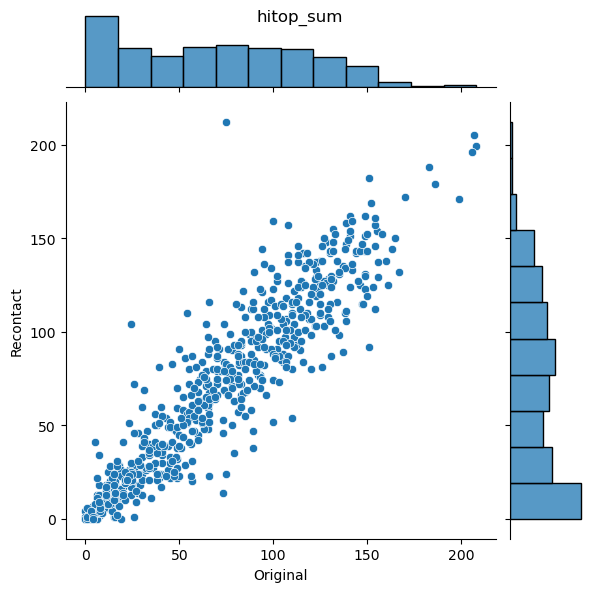

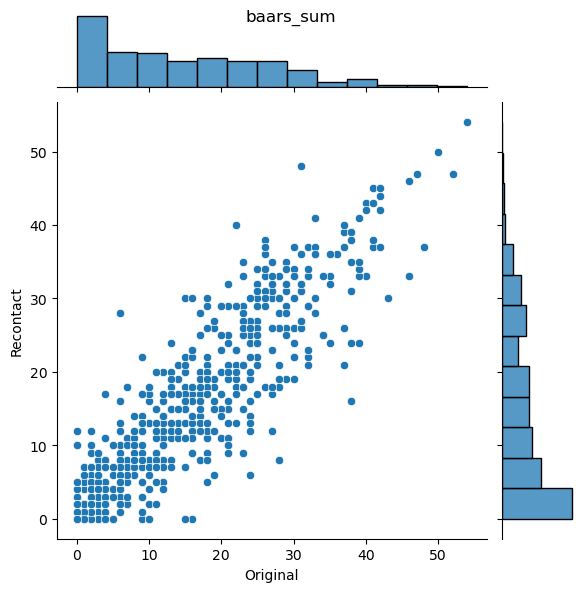

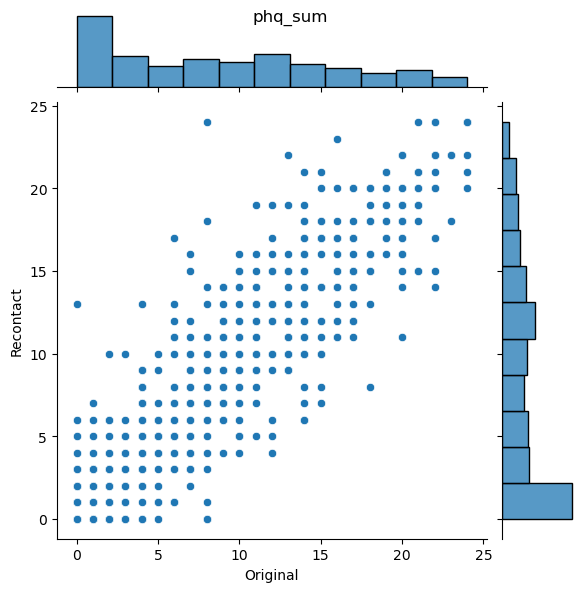

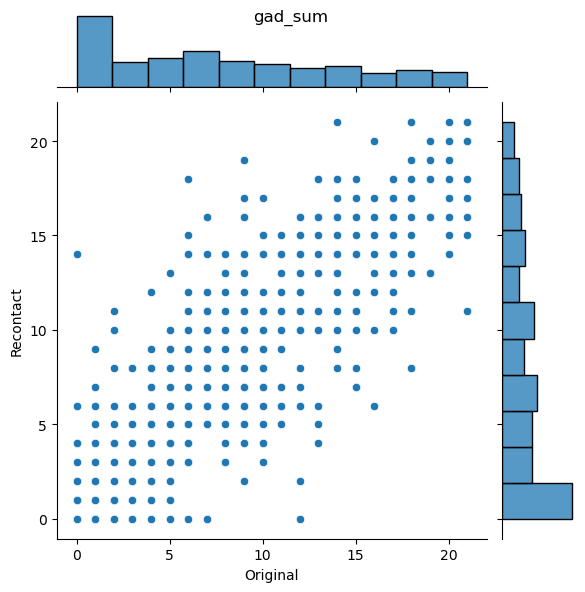

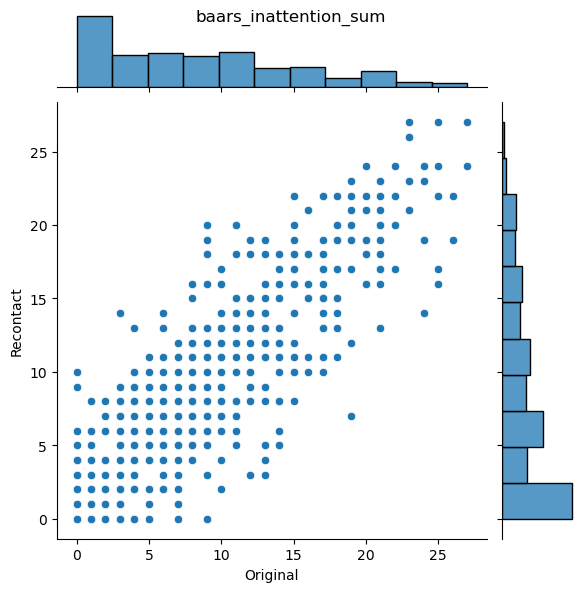

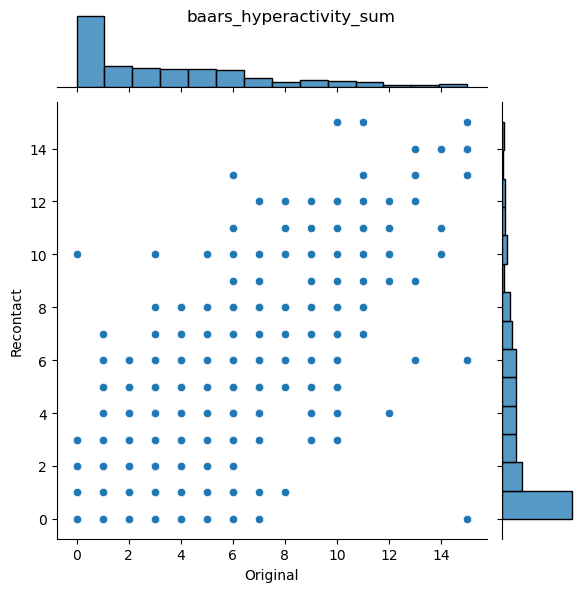

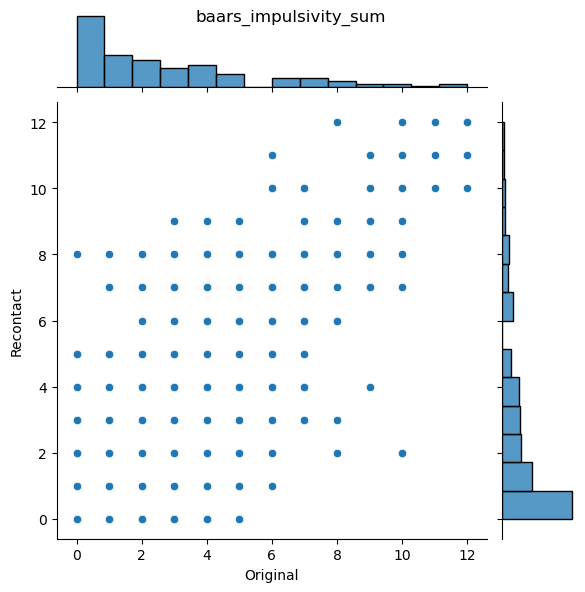

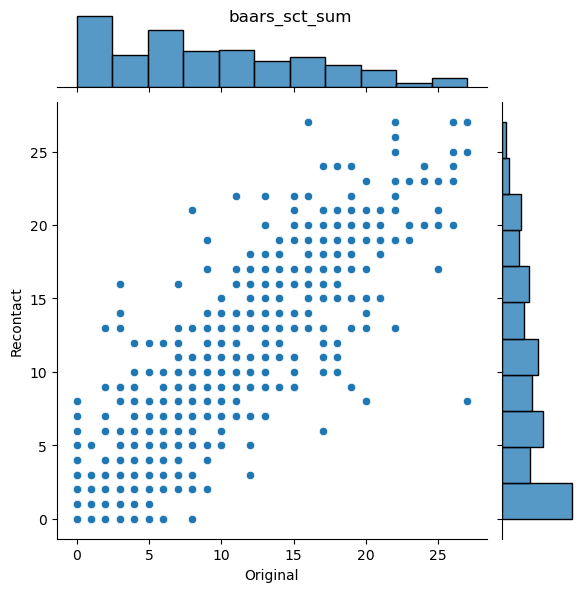

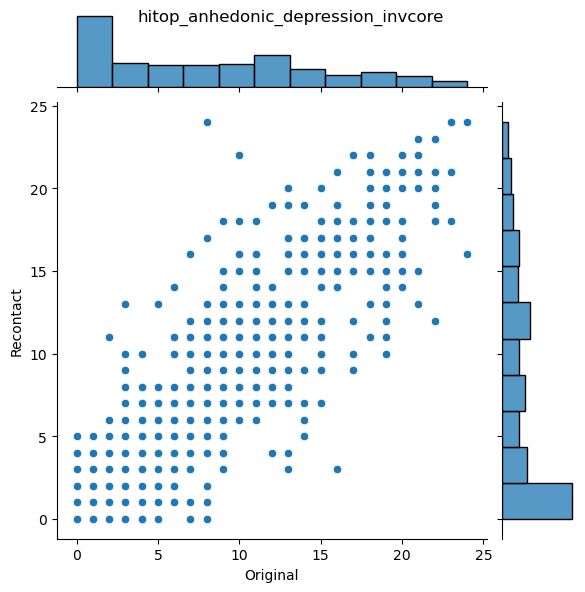

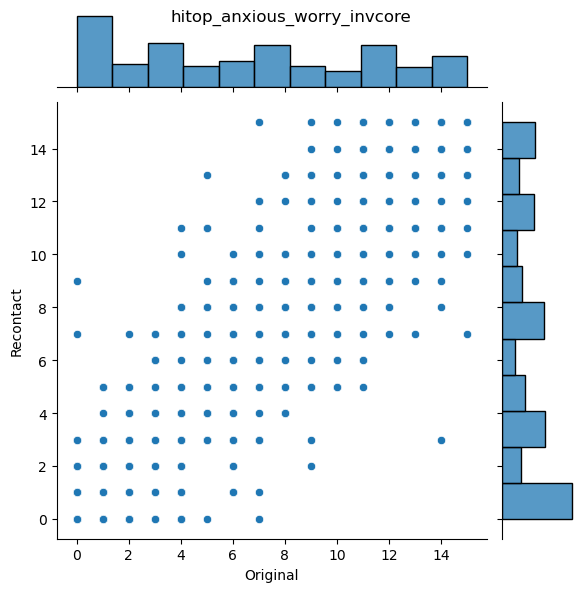

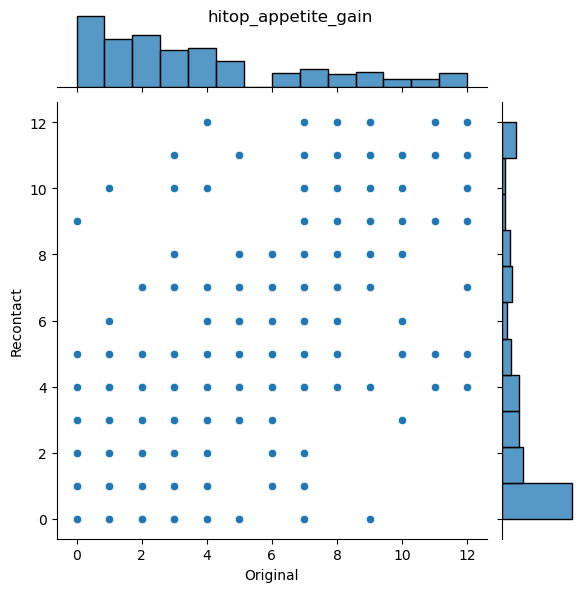

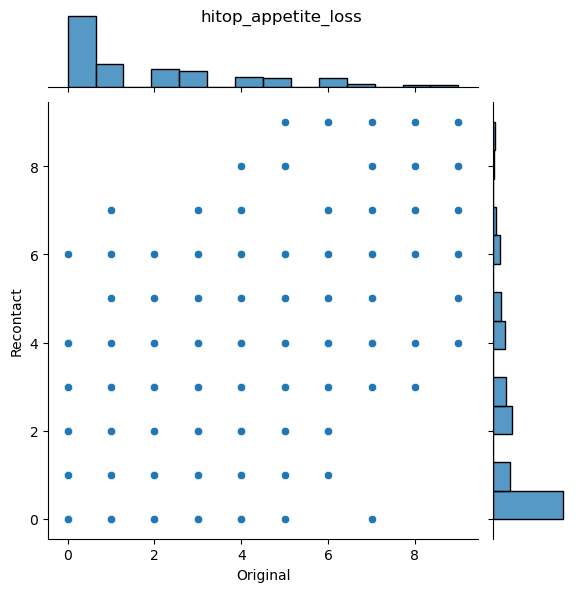

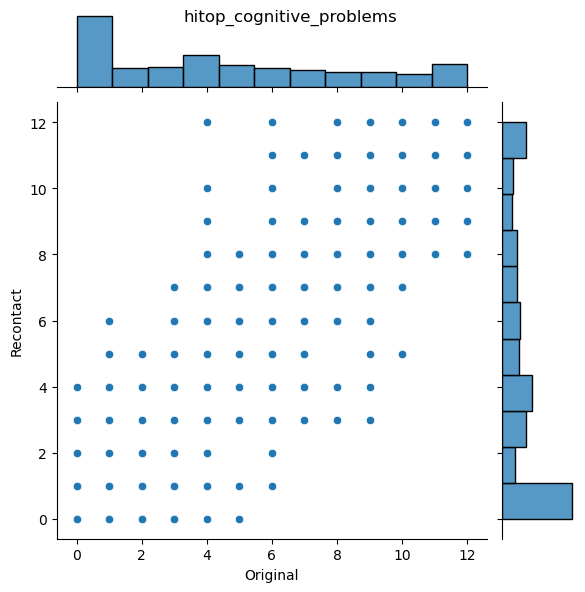

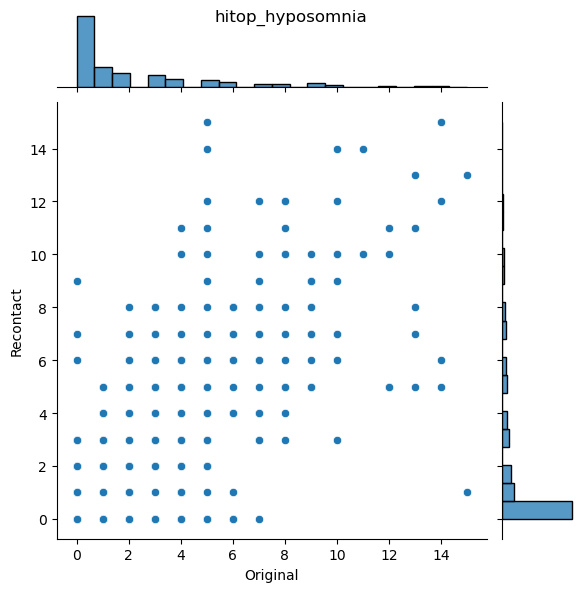

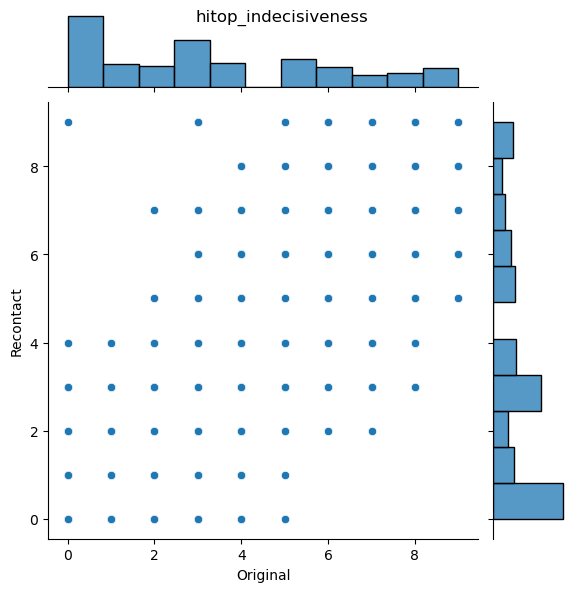

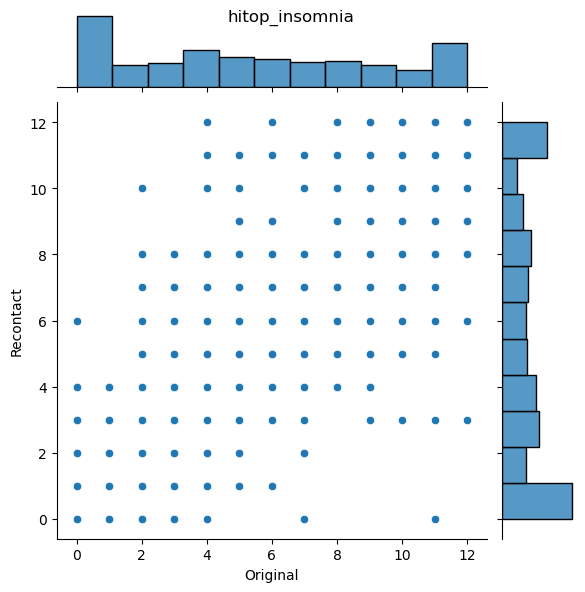

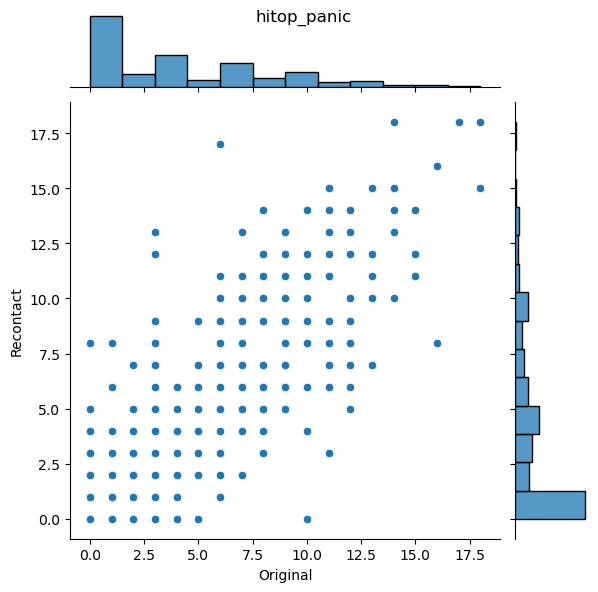

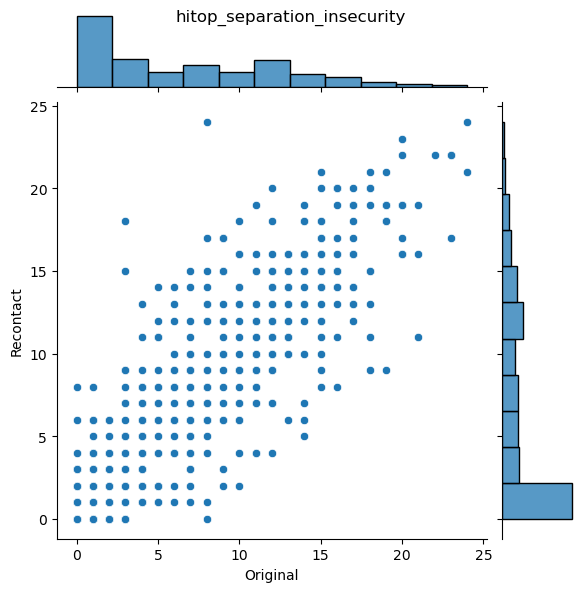

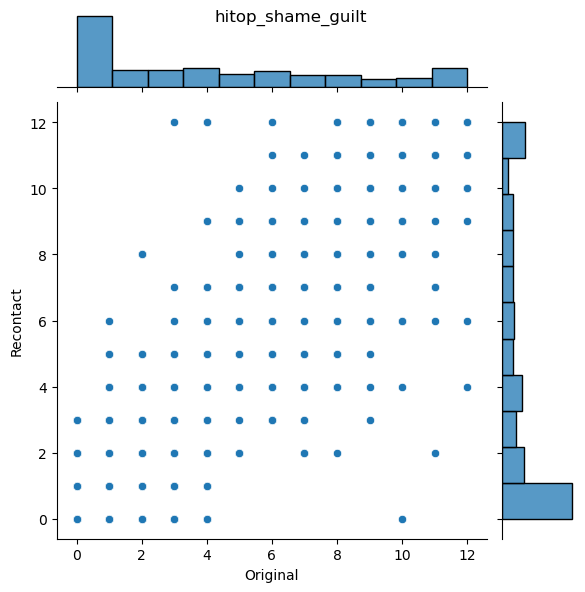

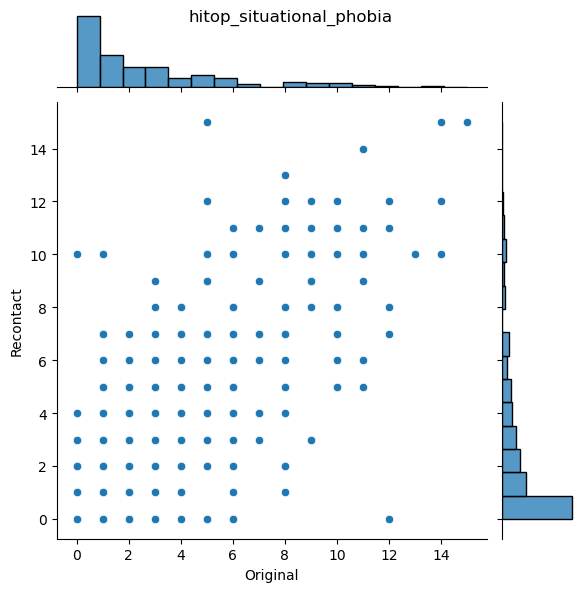

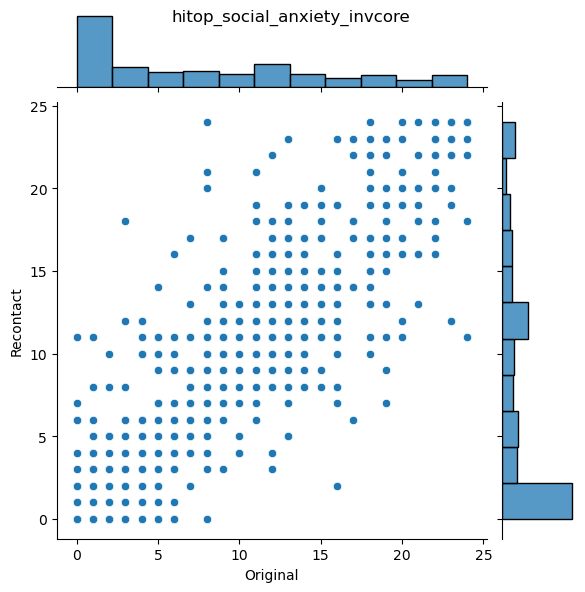

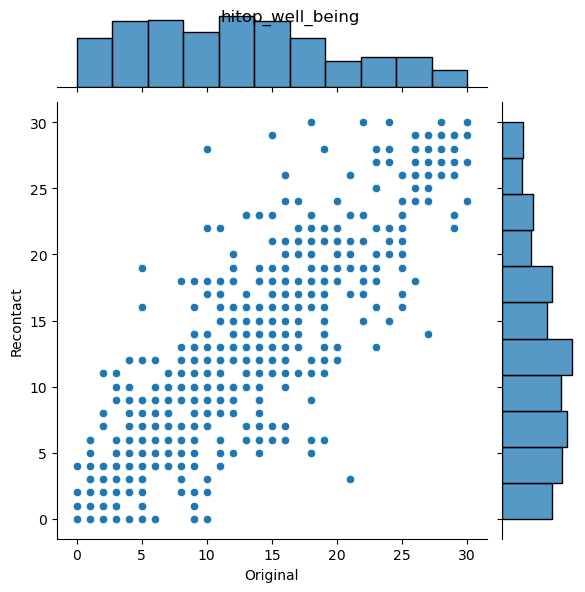

In [36]:
for measure in measures_for_icc:
    if 'bothered' not in measure:
        do_icc(mydata, measure)

In [37]:
results_table = create_table(mydata, measures_for_icc)
results_table

hitop_sum
hitop_sum
baars_sum
baars_sum


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


phq_sum
phq_sum
gad_sum
gad_sum


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

baars_inattention_sum
baars_inattention_sum
baars_hyperactivity_sum
baars_hyperactivity_sum


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


baars_impulsivity_sum
baars_impulsivity_sum
baars_sct_sum
baars_sct_sum


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


hitop_anhedonic_depression_invcore
hitop_anhedonic_depression_invcore
hitop_anxious_worry_invcore
hitop_anxious_worry_invcore


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


hitop_appetite_gain
hitop_appetite_gain
hitop_appetite_loss
hitop_appetite_loss


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


hitop_cognitive_problems
hitop_cognitive_problems
hitop_hyposomnia
hitop_hyposomnia


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


hitop_indecisiveness
hitop_indecisiveness
hitop_insomnia
hitop_insomnia


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


hitop_panic
hitop_panic
hitop_separation_insecurity
hitop_separation_insecurity


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


hitop_shame_guilt
hitop_shame_guilt
hitop_situational_phobia
hitop_situational_phobia


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


hitop_social_anxiety_invcore
hitop_social_anxiety_invcore
hitop_well_being
hitop_well_being


/var/folders/b4/12v1kgbx0k7fmf8dt29hh7bc0000gs/T/ipykernel_62291/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


,Type,Description,ICC,F,df1,df2,pval,CI95%,Measure
1,ICC2,Single random raters,0.927,26.457,433,433,0.0,"[0.91, 0.94]",hitop_sum
1,ICC2,Single random raters,0.889,16.992,433,433,0.0,"[0.87, 0.91]",baars_sum
1,ICC2,Single random raters,0.897,18.370,433,433,0.0,"[0.88, 0.91]",phq_sum
1,ICC2,Single random raters,0.860,13.218,433,433,0.0,"[0.83, 0.88]",gad_sum
1,ICC2,Single random raters,0.869,14.210,433,433,0.0,"[0.84, 0.89]",baars_inattention_sum
1,ICC2,Single random raters,0.767,7.609,433,433,0.0,"[0.72, 0.8]",baars_hyperactivity_sum
1,ICC2,Single random raters,0.804,9.162,433,433,0.0,"[0.77, 0.83]",baars_impulsivity_sum
1,ICC2,Single random raters,0.873,14.710,433,433,0.0,"[0.85, 0.89]",baars_sct_sum
1,ICC2,Single random raters,0.884,16.299,433,433,0.0,"[0.86, 0.9]",hitop_anhedonic_depression_invcore
1,ICC2,Single random raters,0.871,14.562,433,433,0.0,"[0.85, 0.89]",hitop_anxious_worry_invcore


In [38]:
# put measure first
# shift column 'Name' to first position 
first_column = results_table.pop('Measure') 
  
# insert column using insert(position,column_name, 
# first_column) function 
results_table.insert(0, 'Measure', first_column)

results_table

,Measure,Type,Description,ICC,F,df1,df2,pval,CI95%
1,hitop_sum,ICC2,Single random raters,0.927,26.457,433,433,0.0,"[0.91, 0.94]"
1,baars_sum,ICC2,Single random raters,0.889,16.992,433,433,0.0,"[0.87, 0.91]"
1,phq_sum,ICC2,Single random raters,0.897,18.370,433,433,0.0,"[0.88, 0.91]"
1,gad_sum,ICC2,Single random raters,0.860,13.218,433,433,0.0,"[0.83, 0.88]"
1,baars_inattention_sum,ICC2,Single random raters,0.869,14.210,433,433,0.0,"[0.84, 0.89]"
1,baars_hyperactivity_sum,ICC2,Single random raters,0.767,7.609,433,433,0.0,"[0.72, 0.8]"
1,baars_impulsivity_sum,ICC2,Single random raters,0.804,9.162,433,433,0.0,"[0.77, 0.83]"
1,baars_sct_sum,ICC2,Single random raters,0.873,14.710,433,433,0.0,"[0.85, 0.89]"
1,hitop_anhedonic_depression_invcore,ICC2,Single random raters,0.884,16.299,433,433,0.0,"[0.86, 0.9]"
1,hitop_anxious_worry_invcore,ICC2,Single random raters,0.871,14.562,433,433,0.0,"[0.85, 0.89]"
